# Dark Photon Sommerfeld Notebook

This notebook creates an external file which stores an arbitrary amount of Sommerfeld calculations to be later interpolated.

## Initialize Notebook

In [1]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

    
sys.meta_path.append(NotebookFinder())


print ('Complete')

Complete


In [2]:
from MasterFunctions_Annihilation import *
from MasterFunctions_Capture import photonKappa_0
from MasterFunctions_Graphing import *

print ()
print ('All notebooks imported')

importing Jupyter notebook from MasterFunctions_Annihilation.ipynb
importing Jupyter notebook from MasterFunctions_ModelData.ipynb
------ MasterFunctions_ModelData Imported ------
------ MasterFunctions_Annihilation Loaded ------
importing Jupyter notebook from MasterFunctions_Capture.ipynb
------ MasterFunctions_Capture Imported ------
importing Jupyter notebook from MasterFunctions_Graphing.ipynb
------ MasterFunctions_Graphing Loaded ------

All notebooks imported


# Create External Sommerfeld csv File

This noteook serves to create an external file which contains an arbitrary number of $m_A$ and $\langle S_s \rangle$ points to be interpolated later.

The external file has the following column headers:

    Counter, mX[GeV], mA[GeV], ThermAvgSommerfeld, Kappa0[GeV5]

- Counter serves as an index to loop through
- m_X is specified by the user shortly after the file is created 
- m_A is a list of numbers ranging from $0.01$ GeV to $10$ GeV with arbitrary spacing and density. Since these will each correspond to a $\langle S_s \rangle(m_A)$ to be interpolated later, it is suggested to use logarithmic spacing with a high density $(N\geq2500)$
- ThermAvgSommerfeld is the corresponding $\langle S_s \rangle(m_A)$ point



## Recipie

The final output of this notebook is a graph of $\langle S_s \rangle$ versus $m_A$ for $0.01$ GeV $\leq m_A \leq 10$ GeV. We produce this graph with the following recipie:

1). Define the point density of mediator values $m_A$ as a DataFrame object

2). Write that DataFrame to an external .csv file

3). Define the dark matter mass $m_X$

4). 


## Initialize Paramter Arrays

In [19]:
num = 2500

mALogRange = np.logspace(-2, 1, num, base = 10)
mAArray = []

counter = 0
for mATemp in mALogRange:
                 #( Counter, m_X[GeV], m_A[Gev], ThermAvgSommerfeld, Kappa0[GeV5])
    mAArray.append([counter, ' '     , mATemp  , 'None'            , ' '])
    counter += 1

print ('Complete')

Complete


## Create and Write the DataFrame to a .csv

Filenames must follow the convention:

    <#><Unit>Sommerfeld.csv

including the ".csv" extension.

For example, if $m_X = 100$ GeV,

    100GeVSommerfeld.csv

In [20]:
masterSommerfeldDataFrame = \
    pd.DataFrame(mAArray,\
                 columns = \
                 ['Counter','mX[GeV]', 'mA[GeV]', 'ThermAvgSommerfeld', 'Kappa0[GeV5]'])

SommerFile = input('Sommerfeld Filename: ')
writeFile = photonSommerfeldPath(SommerFile)

masterSommerfeldDataFrame.to_csv(writeFile,index=False)
print ('Complete')

Sommerfeld Filename: 500GeVSommerfeld.csv
Complete


## Define $m_X$ Value

In this cell, the user inputs a specific dark matter mass to a given Sommerfeld file.

The units of the mediator must be in GeV.

In [24]:
SommerFile = input('File Name: ')
writeFile = photonSommerfeldPath(SommerFile)

dataFrame = pd.read_csv(writeFile , sep = ',')

m_XValue = float(input('m_X [GeV]: '))
kappa0Value = 'None'

dataFrame.set_value(0, 'mX[GeV]', m_XValue)
dataFrame.set_value(0, 'Kappa0[GeV5]', kappa0Value)

dataFrame.to_csv(writeFile, index=False)

print ('Complete')

File Name: 500GeVSommerfeld.csv
m_X [GeV]: 500
Complete


## Sanity Check

This cell is to verify that there are 5 columns:

    Counter, mX[GeV], mA[GeV], ThermAvgSommerfeld, Kappa0
   
1). Counter should contain integers starting at 0

2). m_X should have the appended value of mX from the previous cell. This should also match the filename

3). mA should take the values defined by the "Initialize Parameter Array" cell and match the length of the Counter column

4). ThermAvgSommerfeld, at this point, should be the same length as mA with every entry "None"

5). Kappa0 should have a single entry reading "None"


In [25]:
filename = input('Sommerfeld File: ')
writeFile = photonSommerfeldPath(filename) 

dataFrame = pd.read_csv(writeFile,sep = ',')

print (dataFrame)

print ('Complete')

Sommerfeld File: 500GeVSommerfeld.csv
      Counter mX[GeV]    mA[GeV]  ThermAvgSommerfeld Kappa0[GeV5]  \
0           0   500.0   0.010000   64000.10928302079         None   
1           1           0.010028   37032.62484625713                
2           2           0.010055  24273.234231006507                
3           3           0.010083  17333.715111865095                
4           4           0.010111  13181.884886510143                
5           5           0.010139  10524.409749639546                
6           6           0.010167   8739.338627773714                
7           7           0.010195   7499.461577840805                
8           8           0.010224   6620.443729898426                
9           9           0.010252   5992.957697390631                
10         10           0.010280   5549.807770993179                
11         11           0.010309   5248.978065123436                
12         12           0.010337   5064.498854437348             

### Calculate File Values
In this cell, we:

1). Determine the correct display units for the dark matter mass

2). Calculate Kappa0

2). Calculates the Sommerfeld enhancement $\langle S_s \rangle$ given each $m_A$ by looping down the list of $m_A$ values 

After each itteration of calculations, the datafile is updated and overwritten, but there is a manual overwrite in the next cell just for good measure

In [26]:
sommerFile = input('Sommerfeld Filename: ')
writeFile = photonSommerfeldPath(sommerFile)

dataIn = pd.read_csv(writeFile,sep = ',')

# Define the loop range
looprange = len(dataIn['Counter'])

# Read in m_X value
Filem_X = float(dataIn.loc[0,'mX[GeV]'])
    
##################################
# Calculate Kappa0
##################################
testKappa0 = dataIn.loc[0,'Kappa0[GeV5]']

if (testKappa0 == 'None'):
    print ('Calculating Kappa0...')
    
    kappa0Value = float(photonKappa_0(Filem_X, 1./137))
    
    dataIn.set_value(0, 'Kappa0', kappa0Value)
    dataIn.to_csv(writeFile, index=False)
    print('Kappa0 value calculated and set')
    
elif (testKappa0 != 'None'):
    print ('Kappa0 value already calculated')


dataIn.set_value(0, 'Kappa0[GeV5]', kappa0Value)
dataIn.to_csv(writeFile, index=False)    
    
##################################
# Calculate the Sommerfeld enhancements
##################################

finishedCounter = 0
print ('-------------------')
print ('Starting Sommerfeld Calculations...')
for index in range(0,looprange):
    ##################################
    # Initialize Parameters
    m_AValue = dataIn.loc[index,'mA[GeV]']
    testSomm = dataIn.loc[index,'ThermAvgSommerfeld']
    
    if (testSomm == 'None'):    
        alpha_X = alphaTherm(Filem_X, m_AValue)
        thermAvgSomm = thermAvgSommerfeld(Filem_X, m_AValue, alpha_X)

        dataIn.set_value(index,'ThermAvgSommerfeld', thermAvgSomm)
        dataIn.to_csv(writeFile, sep=',', index=False)   
        
        finishedCounter +=1
        if (index%20 == 0):
            print ('Index: {0} recorded'.format(index))
        
    elif(testSomm != 'None'):
        finishedCounter +=1
        
    if (finishedCounter == looprange):
        print ('-------------------')
        print ('All Calculations Complete')
        
    
dataIn.to_csv(writeFile, index=False)
print ('Complete')

Sommerfeld Filename: 500GeVSommerfeld.csv
Calculating Kappa0...
Kappa0 value calculated and set
-------------------
Starting Sommerfeld Calculations...
Index: 360 recorded
Index: 380 recorded
Index: 400 recorded
Index: 420 recorded
Index: 440 recorded
Index: 460 recorded
Index: 480 recorded
Index: 500 recorded
Index: 520 recorded
Index: 540 recorded
Index: 560 recorded
Index: 580 recorded
Index: 600 recorded
Index: 620 recorded
Index: 640 recorded
Index: 660 recorded
Index: 680 recorded
Index: 700 recorded
Index: 720 recorded
Index: 740 recorded
Index: 760 recorded
Index: 780 recorded
Index: 800 recorded
Index: 820 recorded
Index: 840 recorded
Index: 860 recorded
Index: 880 recorded
Index: 900 recorded
Index: 920 recorded
Index: 940 recorded
Index: 960 recorded
Index: 980 recorded
Index: 1000 recorded
Index: 1020 recorded
Index: 1040 recorded
Index: 1060 recorded
Index: 1080 recorded
Index: 1100 recorded
Index: 1120 recorded
Index: 1140 recorded
Index: 1160 recorded
Index: 1180 recorde

### Manual Overwrite

In [27]:
dataIn.to_csv(writeFile, index=False)

print ('Complete')

Complete


# Plot Sommerfeld Data

The following section takes in a completed Sommerfeld file and plots the Sommerfeld enhancement versus mediator mass.

## Read in Sommerfeld Data

In the following cell, the user inputs a completed Sommereld data file to be graphed.

In [28]:
sommerFile = input('Sommerfeld Data: ')
readFile = photonSommerfeldPath(sommerFile)

dataIn = pd.read_csv(readFile, sep = ',')

print ('Complete')

Sommerfeld Data: 500GeVSommerfeld.csv
Complete


## Plot Sommerfeld Data

This cell:

1). Extracts the 'mA' and 'ThermAvgSommerfeld' columns from the specified file

2). Plots ThermAvgSommerfeld vs. mA

If the Sommerfeld file isn't fully calculated, Python will throw an error. If the Sommerfeld file isn't complete, run the "Calculate File Values" cell again on the file in question.

Complete


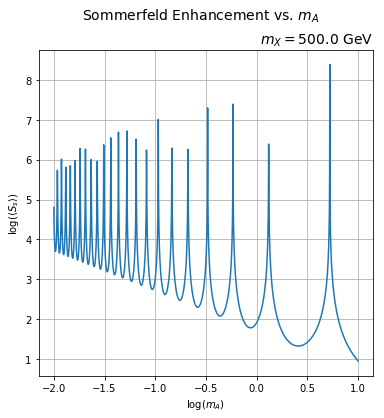

In [29]:
#####################
# Extract Plot Data
#####################
mAList = dataIn['mA[GeV]']
SommerfeldList = dataIn['ThermAvgSommerfeld']
Filem_X = float(dataIn.loc[0,'mX[GeV]'])

##################################
# Determine the diplay Units of m_X 
##################################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X*10**-3
    m_XUnit = 'TeV'

#####################
# Plot
#####################
fig = plt.figure(figsize = (6,6))
Plot = plt.plot(np.log10(mAList),np.log10(SommerfeldList))
plt.ylabel(r'$\log( \langle S_s \rangle )$')
plt.xlabel(r'$\log( m_A )$')
plt.suptitle('Sommerfeld Enhancement vs. $m_A$',fontsize = '14')
plt.title(r'$m_X = {0}$ {1}'.format(m_XDisplay, m_XUnit),loc = 'right', fontsize = '14')
plt.grid()

print ('Complete')

# Junk

In [ ]:
rawData = pd.read_csv(photonSignalDataPath('testSignal.csv'))
Filem_X = float(rawData.loc[0,'mX[GeV]'])

#Pull out min / max values
xMin = min(rawData['mA[GeV]'])
xMax = max(rawData['mA[GeV]'])
yMin = min(rawData['Epsilon'])
yMax = max(rawData['Epsilon'])


# Define the dimension of the grid. 
# For an n x n grid, this will pull out the number "n"
gridDim = int(rawData.loc[0,'Resolution'])



#########################################
# Create the n x n grid
#########################################
# Logarithmic Spacing
xLogRange = np.logspace(xMin, xMax, gridDim, base = 10)
yLogRange = np.logspace(yMin, yMax, gridDim, base = 10)

xLinRange = np.linspace(xMin, xMax, gridDim)
yLinRange = np.linspace(yMin, yMax, gridDim)

#########################################
# Read in and reshape the Contour data
#########################################
# This reads in contour data as a single column,
#     but we reshape it to a 2D, n x n array to fit the grid

z = [rawData['IceCubeSignal']]
SignalData = np.reshape(z, (len(xLinRange), len(yLinRange)))

print ('Complete')

In [ ]:
from matplotlib import ticker


##############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X * 10**-3
    m_XUnit = 'TeV'
    
    
###############################
# Define X,Y tickmarks
###############################
# xTicks = np.linspace(xMin, xMax, 10)
# yTicks = np.linspace(yMin, yMax, 10)
# xTicks = np.logspace((xMin), (xMax), 7, base = 10)
# yTicks = np.logspace(np.log10(yMin),np.log10(yMax),7, base = 10)
    
###############################
# Actual Plotting Stuff
###############################
# fig0 = plt.figure(figsize = (8,6))
fig0, ax0 = plt.subplots(figsize = (8,6))
# fig0, ax0 = plt.add_subplot(111)
# ax0.set_xticks(xTicks)
# ax0.set_yticks(yTicks)

CP = ax0.contour(np.log10(xLogRange), np.log10(yLogRange), \
                 np.log10(SignalData.transpose()),\
                 levels=[0,1,2,3],\
#                  locator=ticker.LogLocator()
                )
xloc, xlabel = xticks()
# plt.clabel(CP, inline=1, fontsize=20., fmt=ticker.LogFormatterMathtext())

plt.xlabel(r'$m_A$ $[GeV]$', fontsize = 13)
plt.ylabel(r'$\varepsilon$', fontsize = 13)
plt.suptitle('IceCube Events', fontsize = 14)
plt.title(r'$m_X$ = {0} {1}'.format(m_XDisplay, m_XUnit), loc = 'right', fontsize = 13)
# plt.axis([xMin,xMax,yMin,yMax])
# plt.clabel(CP, inline=1, fontsize=12)
# plt.colorbar()
plt.grid()